<a href="https://colab.research.google.com/github/ayaamr11/Pose-Detection/blob/main/Pose_detection_version1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import glob
from pathlib import Path
import math

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import imageio
from mlxtend.image import extract_face_landmarks


# Connect to my drive

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!ls "/content/drive/My Drive/Colab Notebooks/machine_learning_projects_data"

# Read data

In [ ]:
#unzip folder from drive
!unzip "/content/gdrive/MyDrive/Colab Notebooks/machine_learning_projects_data/AFLW2000-3D_.zip"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/machine_learning_projects_data/AFLW2000-3D_.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mex

In [ ]:
#read Yaw, Pitch and Roll
def readMat_pose(filename):
    return scipy.io.loadmat(filename)['Pose_Para'][0][0:3] * 180/ math.pi


In [ ]:
#read all IMAGE points
def readMat_2d_pts(filename):
    return scipy.io.loadmat(filename)['pt3d_68'][0:2] 


In [ ]:
#retrive image poses and points into dataframe
def build_dataFrame():
  xList = []
  yList = []
  imag=['imag_name']
  posList=["yaw","pitch","roll"]
  for i in range(1,69):
    xFeature= "x" + str(i)
    yFeature= "y" + str(i)
    xList.append(xFeature)
    yList.append(yFeature)
  colNames =  xList + yList + posList +imag

  df=pd.DataFrame(columns=colNames)

  for file in glob.glob("/content/AFLW2000/*.mat"):
   #print(file)
   
   pointsList = readMat_2d_pts(file)
   poseList = readMat_pose(file)
   image=file

   record = [*pointsList.flatten().tolist(),*poseList.tolist(),image]
   #print(record)
   df.loc[len(df)] = record
  return df
  
  


In [ ]:
df = build_dataFrame()

In [ ]:
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y63,y64,y65,y66,y67,y68,yaw,pitch,roll,imag_name
0,110.781883,115.366936,120.861038,128.689941,142.386475,166.739502,193.466522,219.661331,243.571136,254.383240,...,300.086823,300.901306,309.533752,308.345886,308.255676,308.211792,11.925362,-43.521305,-9.335773,/content/AFLW2000/image02291.mat
1,175.971008,183.529510,193.345062,202.472900,211.186447,220.720612,229.674271,241.398041,263.925446,288.036194,...,306.461060,304.605530,296.816620,304.593201,307.061462,308.505615,-17.925489,20.135757,-20.641628,/content/AFLW2000/image01093.mat
2,179.302612,173.087753,169.512161,166.707169,164.822144,166.236252,169.679810,177.175415,199.540558,231.369003,...,299.333740,303.674896,318.696228,315.811401,312.884521,308.466339,-0.988037,16.630089,17.114134,/content/AFLW2000/image03811.mat
3,148.684265,136.079468,127.584877,120.811272,118.160187,122.551949,134.835373,152.824905,178.748016,207.216415,...,309.582611,314.816711,322.905212,315.473389,310.440552,303.086121,-10.841365,-2.339459,30.680740,/content/AFLW2000/image02032.mat
4,151.592285,158.832062,169.952469,179.714264,189.232071,198.914062,207.653442,221.006897,247.240341,275.796631,...,299.607574,297.260101,298.138275,304.134888,307.713867,309.991699,5.928407,14.267451,-12.385500,/content/AFLW2000/image02217.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,107.598106,111.735794,117.324387,123.623062,135.695343,155.629105,179.767075,206.427490,229.347076,239.185593,...,297.961548,293.990356,286.000305,301.593628,306.285889,308.485168,-23.860794,-48.563221,-3.970054,/content/AFLW2000/image03728.mat
1996,107.864395,112.408936,120.842224,129.308472,142.465454,161.143127,181.026154,203.082031,236.353104,268.593994,...,322.093567,320.123352,304.329498,320.529999,323.965546,322.465393,-21.084620,-0.334111,-3.107993,/content/AFLW2000/image01000.mat
1997,110.739471,114.106339,118.382866,124.476288,136.100723,155.710571,179.516754,206.219711,229.498199,239.413696,...,304.866577,302.863892,298.423828,308.377533,311.213715,311.744659,-13.342536,-44.527225,-1.381501,/content/AFLW2000/image03686.mat
1998,147.614777,156.657715,166.381744,176.205429,188.085907,201.469498,215.693314,232.771851,257.590149,281.144226,...,304.366699,303.441711,300.147644,308.040741,309.769379,309.646484,-30.956585,9.733699,-15.132177,/content/AFLW2000/image00075.mat


In [ ]:
df[df["imag_name"] =="/content/AFLW2000/image00002.mat"]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y63,y64,y65,y66,y67,y68,yaw,pitch,roll,imag_name
608,121.868034,122.367607,126.819237,130.831787,137.523132,148.521729,161.528015,182.876678,213.940063,248.005371,...,313.233856,315.107117,322.384613,330.965576,330.701965,324.90387,-22.874239,1.044306,4.908885,/content/AFLW2000/image00002.mat


In [ ]:
df=df.drop(["imag_name"],axis=1)

# Distribution of outputs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


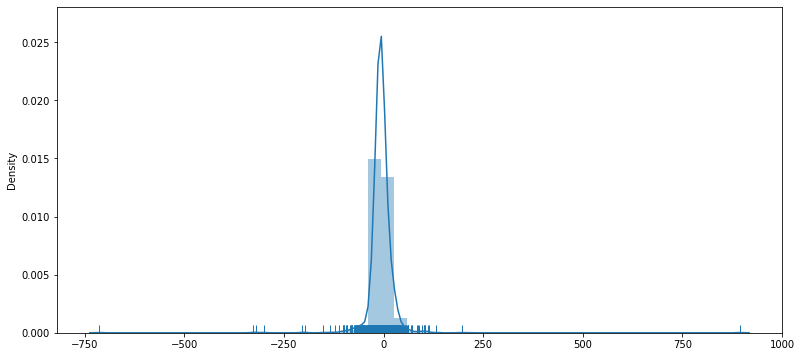

In [ ]:
plt.figure(figsize=(13,6))
sns.distplot(df[['yaw']],rug=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


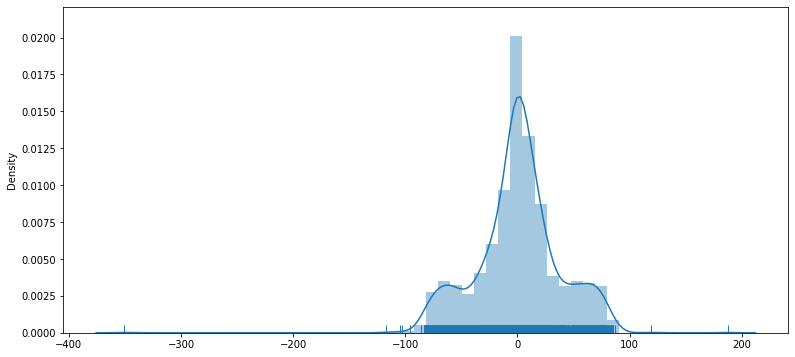

In [ ]:
plt.figure(figsize=(13,6))
sns.distplot(df[['pitch']],rug=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


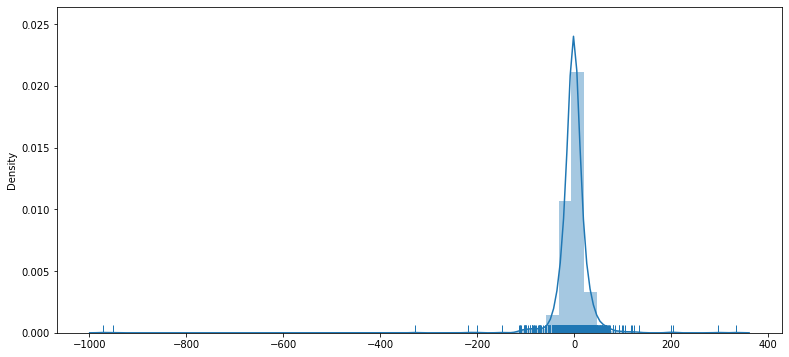

In [ ]:
plt.figure(figsize=(13,6))
sns.distplot(df[['roll']],rug=True)
plt.show()

# Split data

In [ ]:
out=["yaw","pitch","roll"]

In [ ]:
y=df[out]
X=df[df.columns.drop(out)]

In [ ]:
y_yaw=y[['yaw']]
y_pitch=y[['pitch']]
y_roll=y[['roll']]

In [ ]:
#for multiout models without PCA
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
#for models with one output without PCA
Xyaw_train, Xyaw_test, yyaw_train, yyaw_test = train_test_split( X, y_yaw, test_size=0.2, random_state=42)
Xpitch_train, Xpitch_test, ypitch_train, ypitch_test = train_test_split( X, y_pitch, test_size=0.2, random_state=42)
Xroll_train, Xroll_test, yroll_train, yroll_test = train_test_split( X, y_roll, test_size=0.2, random_state=42)

# Feature Selection

## Kbest selection on yaw, pitch and roll

In [ ]:
selector1 = SelectKBest(score_func=f_regression, k=10)
selector2 = SelectKBest(score_func=f_regression, k=10)
selector3 = SelectKBest(score_func=f_regression, k=10)

XYaw_selected = selector1.fit_transform(Xyaw_train, yyaw_train)
Xpitch_selected = selector2.fit_transform(Xpitch_train, ypitch_train)
XRoll_selected = selector3.fit_transform(Xroll_train, yroll_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
yaw_filter = selector1.get_support()
pitch_filter = selector2.get_support()
roll_filter = selector3.get_support()

features = np.array(X.columns.values)

print(features[yaw_filter],"\n")
print(features[pitch_filter],"\n")
print(features[roll_filter],"\n")

['y1' 'y2' 'y3' 'y4' 'y5' 'y6' 'y29' 'y30' 'y31' 'y35'] 

['x3' 'x14' 'x15' 'x16' 'x29' 'x30' 'x31' 'x33' 'x34' 'x35'] 

['x7' 'x8' 'x9' 'x10' 'x22' 'x23' 'x24' 'x25' 'x28' 'x43'] 



## PCA 

### PCA on all data for multi-output regressors

In [ ]:
#PCA on all data
pca_all = PCA(n_components=0.99)
pca_xtrain = pca_all.fit_transform(X_train)
#use tranform only on the test set 
pca_xtest = pca_all.transform(X_test)

### PCA for yaw

In [ ]:
#PCA on yaw data
pca_yaw = PCA(n_components=0.99)
pca_xyaw_train = pca_yaw.fit_transform(Xyaw_train)
pca_xyaw_test = pca_yaw.transform(Xyaw_test)

In [ ]:
pca_xyaw_train.shape

(1600, 9)

### PCA for pitch

In [ ]:
pca_pitch = PCA(n_components=0.99)
pca_xpitch_train = pca_pitch.fit_transform(Xpitch_train)
pca_xpitch_test = pca_pitch.transform(Xpitch_test)

### PCA for roll

In [ ]:
pca_roll = PCA(n_components=0.99)
pca_xroll_train = pca_roll.fit_transform(Xroll_train)
pca_xroll_test = pca_roll.transform(Xroll_test)

# Modeling

## MultiOut regressor

### Using GradientBoostingRegressor

In [ ]:
multiOut_model_one = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(X_train, y_train)
multiOut_model_two = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(pca_xtrain , y_train)

In [ ]:
predictions = multiOut_model_one.predict(X_test)
pca_predictions = multiOut_model_two.predict(pca_xtest)

In [ ]:
print(multiOut_model_one.score(X_train, y_train))
print(multiOut_model_two.score(pca_xtrain, y_train))

0.9952943087665415
0.9874010091306591


In [ ]:
print(multiOut_model_one.score(X_test, y_test))
print(multiOut_model_two.score(pca_xtest, y_test))

0.05179648813760166
0.3273287529392917


In [ ]:
print(mean_squared_error(y_test,predictions,multioutput='raw_values'))
print(mean_squared_error(y_test,pca_predictions,multioutput='raw_values'))

[5800.79904427  354.22543584  530.83238244]
[3753.08719774  343.34466993  622.09408221]


### using RandomForestRegressor

In [ ]:
multiOut_model_three= MultiOutputRegressor(RandomForestRegressor(random_state=0,bootstrap= True)).fit(X_train, y_train)

In [ ]:
predictions = multiOut_model_three.predict(X_test)

In [ ]:
print(multiOut_model_three.score(X_train, y_train))
print(multiOut_model_three.score(X_test, y_test))
print(mean_squared_error(y_test,predictions,multioutput='raw_values'))

0.9258061252780548
0.34883370393306085
[3570.99533738  247.19757958  822.69622264]


## **Yaw**

In [ ]:
#shuffel data first because it improves accurecy
#shuffeld_xyaw_train,shuffeld_yaw_train = shuffle(pca_xyaw_train,yyaw_train)

### XGBRegressor 

In [ ]:
#perform grid search
param = {'nthread':[4],
              'max_depth': [3,4],
              'min_child_weight': [2,4],
              'subsample': [0.5 ,0.7],
              'colsample_bytree': [0.6,0.7,0.8],
              'n_estimators': [500 ,700]}

xgb_gridsearchXGB = GridSearchCV(XGBRegressor(),
                        param,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [ ]:
#xgb_gridsearchXGB.fit(pca_xyaw_train,yyaw_train)

#print(xgb_gridsearchXGB.best_score_)
#print(xgb_gridsearchXGB.best_params_)

In [ ]:
xgboot_yawModel = XGBRegressor(n_estimators=300, max_depth=2, subsample=0.7, colsample_bytree=0.8,min_child_weight=4)
xgboot_yawModel.fit(pca_xyaw_train,yyaw_train)

[10:16:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=2, min_child_weight=4,
             n_estimators=300, subsample=0.7)

In [ ]:
predictions = xgboot_yawModel.predict(pca_xyaw_test)

In [ ]:
print(xgboot_yawModel.score(pca_xyaw_train,yyaw_train))
print(xgboot_yawModel.score(pca_xyaw_test, yyaw_test))
print(mean_squared_error(yyaw_test,predictions))

0.9457537031946748
-1.3959663540078409
5750.236045734791


### RandomForestRegressor

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,6],
    'max_features': [2,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10 ],
    'n_estimators': [100, 300, 1000]
}

xgb_gridsearchRF= GridSearchCV( estimator = RandomForestRegressor(), param_grid = param_grid, cv = 3, n_jobs = 5, verbose = True )

In [ ]:
# Fit the grid search to the data
# xgb_gridsearchRF.fit( pca_xyaw_train , yyaw_train )
# xgb_gridsearchRF.best_params_

In [ ]:
randomforest_yawModel = RandomForestRegressor(random_state=7,bootstrap= True,n_estimators=250)
randomforest_yawModel.fit( pca_xyaw_train , yyaw_train )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(n_estimators=250, random_state=7)

In [ ]:
predictions = randomforest_yawModel.predict(pca_xyaw_test)

In [ ]:
print(randomforest_yawModel.score(pca_xyaw_train,yyaw_train))
print(randomforest_yawModel.score(pca_xyaw_test,yyaw_test))
print(mean_squared_error(yyaw_test,predictions))

0.9359452315906248
-0.6315595521147284
3915.686266478482


### DecisionTreeRegressor

In [ ]:
dt_yawModel = DecisionTreeRegressor(random_state=0, max_depth=4)

In [ ]:
dt_yawModel.fit(pca_xyaw_train,yyaw_train)
predictions = dt_yawModel.predict(pca_xyaw_test)

In [ ]:
print(dt_yawModel.score(pca_xyaw_train,yyaw_train))
print(dt_yawModel.score(pca_xyaw_test,yyaw_test))
print(mean_squared_error(yyaw_test,predictions))

0.8308513960022367
-1.7527328626176075
6606.463277092699


### voting regressor

In [ ]:
r1 = XGBRegressor(n_estimators=500, max_depth=4, subsample=0.7, colsample_bytree=0.8,min_child_weight=4)
r2 = RandomForestRegressor(random_state=42,bootstrap= True)


VotingRG_yawmodel = VotingRegressor([('lr', r1), ('rf', r2)])
VotingRG_yawmodel.fit(pca_xyaw_train,yyaw_train)


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[10:13:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('lr',
                             XGBRegressor(colsample_bytree=0.8, max_depth=4,
                                          min_child_weight=4, n_estimators=500,
                                          subsample=0.7)),
                            ('rf', RandomForestRegressor(random_state=42))])

In [ ]:
predictions = VotingRG_yawmodel.predict(pca_xyaw_test)

In [ ]:
print(dt_yawModel.score(pca_xyaw_train,yyaw_train))
print(dt_yawModel.score(pca_xyaw_test,yyaw_test))
print(mean_squared_error(yyaw_test,predictions))

0.8308513960022367
-1.7527328626176075
4946.896213741463


## **Pitch**

### XGBRegressor



In [ ]:
xgboot_pitchModel = XGBRegressor(n_estimators=1000, max_depth=4, subsample=0.7, colsample_bytree=0.8)
xgboot_pitchModel.fit(Xpitch_train,ypitch_train)

[16:54:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=4, n_estimators=1000,
             subsample=0.7)

In [ ]:
predictions = xgboot_pitchModel.predict(Xpitch_test)

print(xgboot_pitchModel.score(Xpitch_train,ypitch_train))
print(xgboot_pitchModel.score(Xpitch_test, ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.9999997376674415
0.9931639740722481
9.09223333441099


### random forest regressor (Winner model)

In [ ]:
randomforest_pitchModel =  RandomForestRegressor(random_state=42)
randomforest_pitchModel.fit(pca_xpitch_train,ypitch_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(random_state=42)

In [ ]:
predictions = randomforest_pitchModel.predict(pca_xpitch_test)

print(randomforest_pitchModel.score(pca_xpitch_train,ypitch_train))
print(randomforest_pitchModel.score(pca_xpitch_test,ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.991814219582776
0.8299990472782977
260.29067758670186


## **Roll**

### random search for RandomForestRegressor

In [ ]:
#n_estimators = [200,500,700,1000,1200]
#
#max_features = ['auto', 'sqrt']
#
#max_depth = [10,30,50,80,100]
#max_depth.append(None)
#
#min_samples_split = [2, 5, 10]
#
#min_samples_leaf = [1, 2, 4]
#
#bootstrap = [True, False]
#
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#print(random_grid)

{'n_estimators': [200, 500, 700, 1000, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 30, 50, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rf_random.fit(pca_xroll_train , yroll_train)

In [ ]:
#rf_random.best_params_

### grid search for RandomForestRegressor

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,6],
    'max_features': [2,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10 ],
    'n_estimators': [100, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = 5, verbose = True)


In [ ]:
# Fit the grid search to the data
grid_search.fit(pca_xroll_train , yroll_train)
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [ ]:
randomforest_rollModel =   RandomForestRegressor( random_state=0, bootstrap=False, max_depth=6,
                                                 max_features=5, min_samples_leaf=1,
                                                 min_samples_split=8, n_estimators=300)
randomforest_rollModel.fit(pca_xroll_train , yroll_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=False, max_depth=6, max_features=5,
                      min_samples_split=8, n_estimators=300, random_state=0)

In [ ]:
predictions = randomforest_rollModel.predict(pca_xroll_test)

print(randomforest_rollModel.score(pca_xroll_train,yroll_train))
print(randomforest_rollModel.score(pca_xroll_test,yroll_test))
print(mean_squared_error(yroll_test,predictions))

0.8927487166284488
0.9206406888252198
214.68531977338534


# Test performance on my image

## Extract 68 points

In [ ]:
img = imageio.imread('/content/gdrive/MyDrive/photos/IMG-20210318-WA0107.jpg')
landmarks = extract_face_landmarks(img)
print(landmarks.shape)

(68, 2)


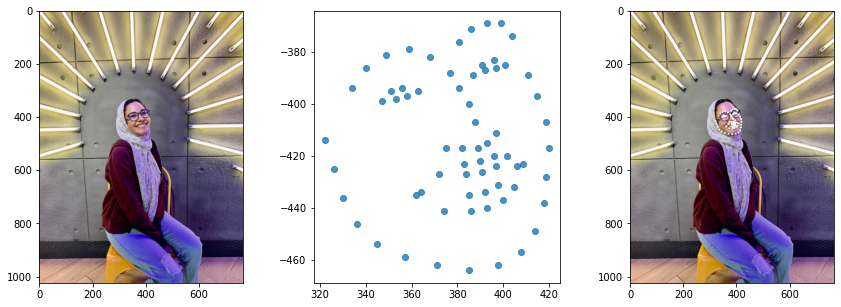

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
ax = fig.add_subplot(1, 3, 3)
img2 = img.copy()

for p in landmarks:
    img2[p[1]-3:p[1]+3, p[0]-3:p[0]+3, :] = (255, 255, 255)

ax.imshow(img2)
plt.show()

In [ ]:
x_img = (landmarks[:,0])
y_img = (landmarks[:,1])


In [ ]:
features = np.concatenate((x_img,y_img))
features = features.reshape(1,-1)
features.shape

(1, 136)

##  Prepare features

In [ ]:
yaw_features = pca_yaw.transform(features)
pitch_features = pca_pitch.transform(features)
roll_features = pca_roll.transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


## Test on best models 

In [ ]:
#pred = multiOut_model_one.predict(features)

In [ ]:
#predicted_yaw = 
predicted_pitch= randomforest_pitchModel.predict(pitch_features)
predicted_roll= randomforest_rollModel.predict(roll_features)

In [ ]:
print(predicted_pitch)
print(predicted_roll)

[69.03250366]
[-5.99896142]
